### PCKF code with only linear terms - To match KF and ENKF with multiple floors

[[0.2]
 [0.3]
 [0.4]]
Forecast PC coefficient matrix is
 [[0.2  0.05 0.03 0.   0.  ]
 [0.3  0.04 0.02 0.   0.  ]
 [0.4  0.06 0.02 0.   0.  ]]
Hk matrix is
 [[1. 0. 0.]
 [0. 1. 0.]]
epsilon is [[ 2.16493494]
 [-0.99065175]]
data matrix is
 [[0.35308402 0.         0.         0.07071068 0.        ]
 [0.22995034 0.         0.         0.         0.07071068]]
forecast covariance is
 [[0.0034 0.0026 0.0036]
 [0.0026 0.002  0.0028]
 [0.0036 0.0028 0.004 ]]
Noise covariance is
 [[0.005 0.   ]
 [0.    0.005]]
Kalman gain is
 [[0.32744043 0.24980784]
 [0.24980784 0.19292852]
 [0.3443505  0.27209839]]
updated state is
 [[0.23262694 0.02363566 0.01518063 0.02315353 0.01766408]
 [0.32472701 0.01979247 0.00864719 0.01766408 0.01364211]
 [0.43365416 0.03189854 0.00422752 0.02434926 0.01924026]]
updated covarince is
 [[0.0016372  0.00124904 0.00172175]
 [0.00124904 0.00096464 0.00136049]
 [0.00172175 0.00136049 0.00199846]]


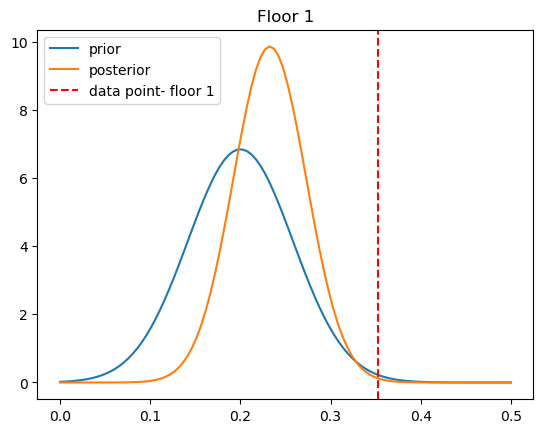

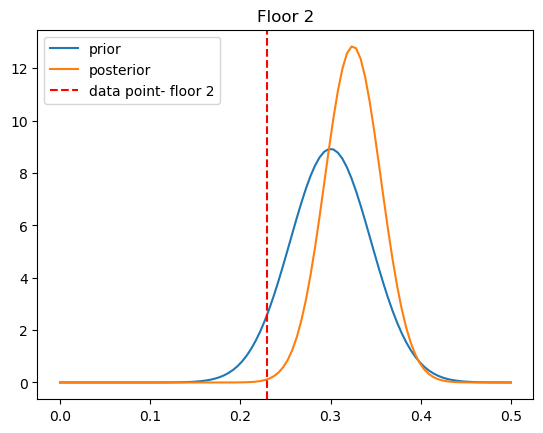

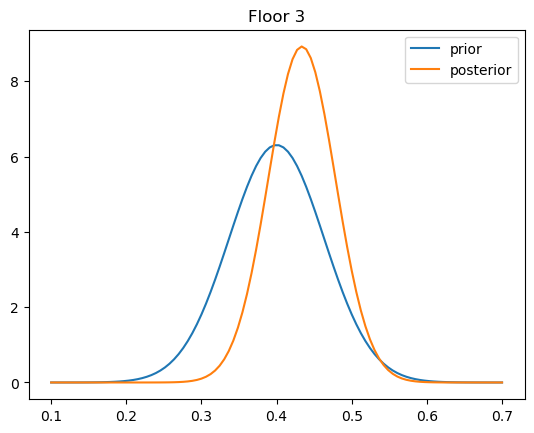

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import norm

floors = 3

observed = 2

pccoeff = floors + observed
## First index is floor number and second is PC coefficient
# First floor
u10 = 0.2
u11 = 0.05
u12 = 0.03

# Second floor
u20 = 0.3
u21 = 0.04
u22 = 0.02

# Third floor
u30 = 0.4
u31 = 0.06
u32 = 0.02



## Creating matrix A_f with all PC coefficient vectors

U0 = np.array([[u10], [u20], [u30]])
U1 = np.array([[u11], [u21], [u31]])
U2 = np.array([[u12], [u22], [u32]])
# U3 = np.array([[u13], [u23], [u33]])

print(U0)

A_f = np.zeros((floors,pccoeff))

A_f[:,0] = U0.reshape(floors)
A_f[:,1] = U1.reshape(floors)
A_f[:,2] = U2.reshape(floors)
# A_f[:,3] = U3.reshape(floors)
print("Forecast PC coefficient matrix is\n", A_f)


### Generating the data vector

Hk = np.zeros((observed,floors))

# Hk = np.zeros((observed,pccoeff))

if(observed == 1): 
    Hk[0,0] = 1
elif (observed == 2):
    Hk[0,0] = 1
    Hk[1,1] = 1
else:
    Hk[0,0] = 1
    Hk[1,1] = 1
    Hk[2,2] = 1

# Hk[2,2] = 1

# for i in range(pccoeff):
#     Hk[:,i] = h_k

## PC coefficients of data

print("Hk matrix is\n", Hk)

dk = np.zeros((observed,pccoeff))

noise = np.eye(observed)
noisevar = 0.005

np.random.seed(106)

nsteps = 1

epsilon = np.random.normal(0,1,size=(observed,nsteps))

print("epsilon is", epsilon)

# noise = noise + epsilon

Gamma = noise * noisevar

H_knoise = np.eye((observed))

# print(noise)
d0 = Hk @ U0 + np.sqrt(noisevar) * epsilon

dk[:,0] = d0.reshape(observed)





for i in range(observed):
    dnoise =  H_knoise @ np.sqrt(Gamma[i,:])
    # print(dnoise)
    # dnoise = dnoise.reshape(observed,1) @ epsilon[i,:].reshape(1,1)
    # dk[:,pccoeff-observed+i] = dnoise.reshape(observed)
    dk[:,pccoeff-observed+i] = dnoise.reshape(observed)
# d1 = np.zeros(floors,1)
# d1 = np.zeros(floors,1)

print("data matrix is\n", dk)


### Constructing covariance matrix

varpc = [1, 1, 1, 1, 1]

P_k = np.zeros((floors,floors))

P_u = np.zeros((floors,floors))

for i in range(1,pccoeff):
    P_k = P_k + varpc[i] * (A_f[:,i].reshape(floors,1) @  (A_f[:,i].reshape(floors,1)).T)


print("forecast covariance is\n", P_k)

print("Noise covariance is\n", Gamma)



K_g = P_k @ Hk.T @ np.linalg.inv(Hk @ P_k @ Hk.T + Gamma)


print("Kalman gain is\n", K_g)


### Update state

# u_a = np.zeros((floors,pccoeff))

A_u = A_f + K_g @ (dk - Hk @ A_f)

# for i in range(pccoeff):
#     u_a[:,i] = A_f[:,i] + K_g @ (dk[:,i].reshape(observed,1) - Hk @ A_f[:,i].reshape(floors,1))

print("updated state is\n", A_u)


for i in range(1,pccoeff):
    P_u = P_u + varpc[i] * (A_u[:,i].reshape(floors,1) @  (A_u[:,i].reshape(floors,1)).T)


print("updated covarince is\n", P_u)



x1 =  np.linspace(0.0,0.5, 100)

x2 =  np.linspace(0.0,0.5, 100)

x3 =  np.linspace(0.1,0.7, 100)


p1 = norm.pdf(x1, loc= u10, scale = np.sqrt(P_k[0,0]))
p2 = norm.pdf(x2, loc= u20, scale = np.sqrt(P_k[1,1]))
p3 = norm.pdf(x3, loc= u30, scale = np.sqrt(P_k[2,2]))


p11 = norm.pdf(x1, loc= A_u[0,0], scale = np.sqrt(P_u[0,0]))
p22 = norm.pdf(x2, loc= A_u[1,0], scale = np.sqrt(P_u[1,1]))
p33 = norm.pdf(x3, loc= A_u[2,0], scale = np.sqrt(P_u[2,2]))


plt.figure(i)
plt.title("Floor 1")
plt.plot(x1,p1,label = 'prior')
plt.plot(x1,p11,label = 'posterior')
plt.axvline(dk[0,0], color='red', linestyle='--', label='data point- floor 1')
plt.legend()
plt.savefig('KF_floor3_1observed.pdf')
plt.show()

plt.figure(i+1)
plt.title("Floor 2")
plt.plot(x2,p2,label = 'prior')
plt.plot(x2,p22,label = 'posterior')
plt.axvline(dk[1,0], color='red', linestyle='--', label='data point- floor 2')
plt.legend()
plt.savefig('KF_floor3_1observed.pdf')
plt.show()

plt.figure(i+2)
plt.title("Floor 3")
plt.plot(x3,p3,label = 'prior')
plt.plot(x3,p33,label = 'posterior')
# plt.axvline(d_k[2], color='red', linestyle='--', label='x = 5')
plt.legend()
plt.savefig('KF_floor3_1observed.pdf')
plt.show()





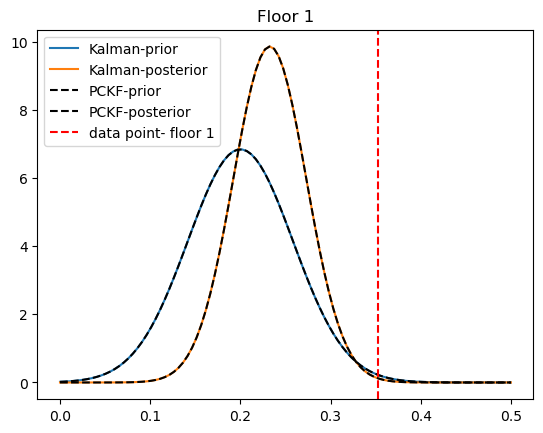

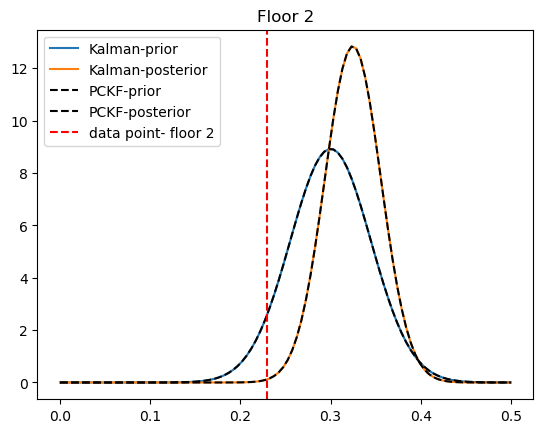

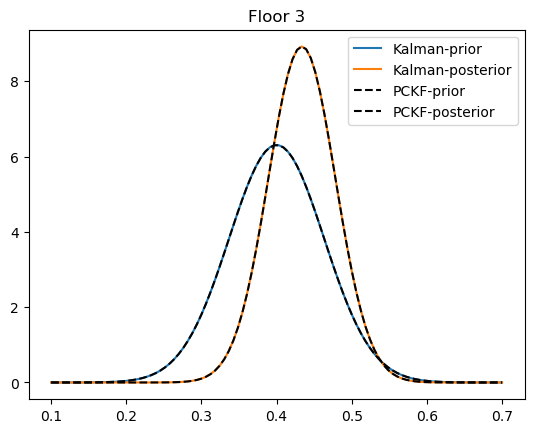

In [3]:



### File containing 1 Kalman filter update with 2 floor measurements 

if(observed == 1):
    npzfile_prior = np.load('./../KF/pdf_prior_1data.npz')
    npzfile_posterior = np.load('./../KF/pdf_update_1data.npz')
else:
    npzfile_prior = np.load('./../KF/pdf_prior_2data.npz')
    npzfile_posterior = np.load('./../KF/pdf_update_2data.npz')




plt.figure(1)
plt.title("Floor 1")
plt.plot(x1,npzfile_prior['x'],label = 'Kalman-prior')
plt.plot(x1,npzfile_posterior['x'],label = 'Kalman-posterior')
plt.plot(x1,p1,'k--',label = 'PCKF-prior')
plt.plot(x1,p11,'k--',label = 'PCKF-posterior')
plt.axvline(dk[0,0], color='red', linestyle='--', label='data point- floor 1')
plt.legend()
plt.savefig('PCKF_floor1_2data.pdf')
plt.show()

plt.figure(2)
plt.title("Floor 2")
plt.plot(x2,npzfile_prior['y'],label = 'Kalman-prior')
plt.plot(x2,npzfile_posterior['y'],label = 'Kalman-posterior')
plt.plot(x2,p2,'k--',label = 'PCKF-prior')
plt.plot(x2,p22,'k--',label = 'PCKF-posterior')
plt.axvline(dk[1,0], color='red', linestyle='--', label='data point- floor 2')
plt.legend()
plt.savefig('PCKF_floor2_2data.pdf')
plt.show()

plt.figure(3)
plt.title("Floor 3")
plt.plot(x3,npzfile_prior['z'],label = 'Kalman-prior')
plt.plot(x3,npzfile_posterior['z'],label = 'Kalman-posterior')
plt.plot(x3,p3,'k--',label = 'PCKF-prior')
plt.plot(x3,p33,'k--',label = 'PCKF-posterior')
plt.legend()
plt.savefig('PCKF_floor3_2data.pdf')
plt.show()
